In [1]:
%pip install qiskit qiskit_aer pylatexenc

  Using cached qiskit_aer-0.17.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached qiskit_aer-0.17.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)


In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity

from qiskit_aer import AerSimulator
from qiskit import transpile


from qiskit.quantum_info import Kraus

import random
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def error_correction(circuit, physical_qubit, syndromes):
  """
  Applies error correction to the quantum circuit based on measured syndromes.

  Args:
    circuit (QuantumCircuit): The quantum circuit to apply error correction to.
    physical_qubit (QuantumRegister): The register of physical qubits.
    syndromes (ClassicalRegister): The classical register holding the syndrome measurements.
  """
  syn_to_fix = {
      0b0001: ('x', 0),   0b1011: ('y', 0),   0b1010: ('z', 0),
      0b1000: ('x', 1),   0b1101: ('y', 1),   0b0101: ('z', 1),
      0b1100: ('x', 2),   0b1110: ('y', 2),   0b0010: ('z', 2),
      0b0110: ('x', 3),   0b1111: ('y', 3),   0b1001: ('z', 3),
      0b0011: ('x', 4),   0b0111: ('y', 4),   0b0100: ('z', 4),
  }
  with circuit.switch(syndromes) as case:
      for syndrome_binary, (gate, qubit) in syn_to_fix.items():
          with case(syndrome_binary):
              getattr(circuit, gate)(physical_qubit[qubit])               # x/y/z gate
  circuit.barrier()
  return None


def random_pauli_error(p, error_index, physical_qubit, circuit):
  """
  Applies a random Pauli error (X, Y, or Z) to a specified physical qubit with a given probability.

  Args:
    p (float): The probability of applying an error.
    error_index (int): The index of the physical qubit to apply the error to.
    physical_qubit (QuantumRegister): The register of physical qubits.
    circuit (QuantumCircuit): The quantum circuit to apply the error to.
  """
  if random.uniform(0, 1) > p:
    return None

  error_type = random.randint(1, 3)
  if error_type == 1:
    circuit.x(physical_qubit[error_index])
  if error_type == 2:
    circuit.y(physical_qubit[error_index])
  if error_type == 3:
    circuit.z(physical_qubit[error_index])
  circuit.barrier()
  return None


def encoder(x, physical_qubit, circuit):
  """
  Encodes the logical state |x> into the 5-qubit code state.

  Args:
    x (int): The classical bit (0 or 1) to encode.
    physical_qubit (QuantumRegister): The register of physical qubits.
    circuit (QuantumCircuit): The quantum circuit to perform the encoding on.
  """
  circuit.cp(np.pi,physical_qubit[0],physical_qubit[1])
  circuit.cx(physical_qubit[0],physical_qubit[1])
  circuit.cp(np.pi,physical_qubit[0],physical_qubit[1])
  circuit.cx(physical_qubit[0],physical_qubit[1])

  circuit.h(physical_qubit[4])
  circuit.s(physical_qubit[4])
  circuit.cz(physical_qubit[4],physical_qubit[3])
  circuit.cz(physical_qubit[4],physical_qubit[1])
  circuit.cy(physical_qubit[4],physical_qubit[0])

  circuit.h(physical_qubit[3])
  circuit.cz(physical_qubit[3],physical_qubit[2])
  circuit.cz(physical_qubit[3],physical_qubit[1])
  circuit.cx(physical_qubit[3],physical_qubit[0])

  circuit.h(physical_qubit[2])
  circuit.cz(physical_qubit[2],physical_qubit[4])
  circuit.cz(physical_qubit[2],physical_qubit[3])
  circuit.cx(physical_qubit[2],physical_qubit[0])

  circuit.h(physical_qubit[1])
  circuit.s(physical_qubit[1])
  circuit.cz(physical_qubit[1],physical_qubit[4])
  circuit.cz(physical_qubit[1],physical_qubit[2])
  circuit.cy(physical_qubit[1],physical_qubit[0])

  if x==1:
      circuit.x(physical_qubit)


  circuit.barrier()
  return None


def measurement(circuit, physical_qubit, log):
    """
    Performs a logical measurement on the encoded state.

    Args:
      circuit (QuantumCircuit): The quantum circuit to perform the measurement on.
      physical_qubit (QuantumRegister): The register of physical qubits.
      log (ClassicalRegister): The classical register to store the measurement result.
    """
    result = QuantumRegister(1, name='result')
    circuit.add_register(result)
    circuit.barrier()
    circuit.h(result)
    for i in range(5):
        circuit.cz(physical_qubit[i], result)
    circuit.h(result)

    circuit.measure(result, log)

def stabilizer(quantim_circuit, ancillas, physical_qubit):
  """
  Applies the stabilizer measurements to the encoded state using ancilla qubits.

  Args:
    quantim_circuit (QuantumCircuit): The quantum circuit to perform the stabilizer measurements on.
    ancillas (AncillaRegister): The register of ancilla qubits.
    physical_qubit (QuantumRegister): The register of physical qubits.
  """
  quantim_circuit.h(ancillas)

  quantim_circuit.cx(ancillas[0], physical_qubit[0])
  quantim_circuit.cz(ancillas[0], physical_qubit[1])
  quantim_circuit.cz(ancillas[0], physical_qubit[2])
  quantim_circuit.cx(ancillas[0], physical_qubit[3])

  quantim_circuit.cx(ancillas[1], physical_qubit[1])
  quantim_circuit.cz(ancillas[1], physical_qubit[2])
  quantim_circuit.cz(ancillas[1], physical_qubit[3])
  quantim_circuit.cx(ancillas[1], physical_qubit[4])

  quantim_circuit.cx(ancillas[2], physical_qubit[0])
  quantim_circuit.cx(ancillas[2], physical_qubit[2])
  quantim_circuit.cz(ancillas[2], physical_qubit[3])
  quantim_circuit.cz(ancillas[2], physical_qubit[4])

  quantim_circuit.cz(ancillas[3], physical_qubit[0])
  quantim_circuit.cx(ancillas[3], physical_qubit[1])
  quantim_circuit.cx(ancillas[3], physical_qubit[3])
  quantim_circuit.cz(ancillas[3], physical_qubit[4])

  quantim_circuit.h(ancillas)
  quantim_circuit.barrier()
  return None


def five_qubit_ECC(p, x):
  """
  Constructs a quantum circuit for the 5-qubit error correction code.

  Args:
    p (float): The probability of a random Pauli error on each qubit.
    x (int): The classical bit (0 or 1) to be encoded.

  Returns:
    QuantumCircuit: The constructed quantum circuit for the 5-qubit ECC.
  """
  physical_qubit = QuantumRegister(size=5, name="Physical Qubit")
  ancillas = AncillaRegister(size = 4, name="Ancilla")
  syndrome = ClassicalRegister(4, name="Syndrome")
  log = ClassicalRegister(1, name="log")
  quantim_circuit = QuantumCircuit(ancillas, physical_qubit, syndrome, log, name="Circuit")

  #quantim_circuit.h(ancillas)


  #quantim_circuit.initialize(logical_state(x), physical_qubit)
  encoder(x, physical_qubit, quantim_circuit)


  for error_index in range(5):
    random_pauli_error(p, error_index, physical_qubit, quantim_circuit)
  quantim_circuit.barrier()

  stabilizer(quantim_circuit, ancillas, physical_qubit)

  quantim_circuit.measure(ancillas, syndrome)

  error_correction(quantim_circuit, physical_qubit, syndrome)


  #decoder(x, physical_qubit, quantim_circuit)
  measurement(quantim_circuit, physical_qubit, log)

  #quantim_circuit.measure(physical_qubit[4], log)

  #quantim_circuit.save_statevector_dict()

  return quantim_circuit

In [11]:

#Assemble success statistics
n = 10

p_vec = np.linspace(0.0, 0.3, num=n)
success_rate = np.zeros(n)
num_iteration = 1000

for i in range(n):
  p_error = p_vec[i]
  for j in range(num_iteration):
    x_encoded = random.randint(0,1)
    qc = five_qubit_ECC(p_error, x_encoded)

    backend = AerSimulator()                # supports mid-circuit measurement
    job     = backend.run(qc, shots=1, memory=True)
    bitstr  = job.result().get_memory()[0]  # e.g.  "1 0101"

    # registers were created as  Syn(4 bits)  +  Log(1 bit)
    log_bit, syn_bits = bitstr.split(' ')   # "0101", "1"

    logical_success = (int(log_bit) == x_encoded)
    if logical_success:
      success_rate[i] += 1/num_iteration

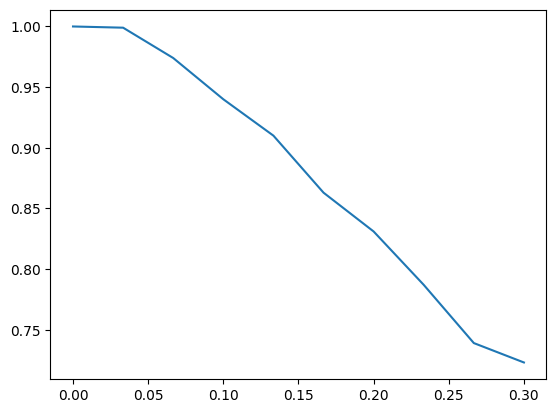

In [12]:
plt.plot(p_vec,success_rate)